# ATMS 523

## Module 6 Project

Submit this code commit back to GitHub by the date and time listed in Canvas.

## Datasets

Use the Storm Prediction Center tornado dataset https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv

Also, use the ENSO, PDO, NAO, and AO dataframe from earlier module.

## Your assignment

1) Aggregate the tornado data over the following states into a monthly count of tornadoes:
   
   - Illinois
   
2. Merge this monthly tornado dataset with the ENSO, PDO, NAO, and AO dataframe created in Module 4 Notebook 1.

3. Create a random forest regression model and use features that include the 4 climate indices to predict the monthly number of tornadoes.  Create a scatter plot of the predicted and observed number of tornadoes over these states.  Report the correlation coefficient and RMSE of your model.

4. Create a one-hot encoding for the month of the year.  Repeat the scatterplot and compare the RMSE and correlation coefficient values.

5. Perform a feature importance and multipass permutation analysis of your features.

6. Create a SHAP Summary Plot showing feature importance and feature effects.

7. Create a SHAP Feature Dependence for the ENSO index.

8. Any observations on the importance of the various features in your model from the XAI techniques you tried?


In [1]:
# Import necessary libraries
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

import numpy as np

import shap

In [2]:
# Open the tornado dataset using Pandas
tornado_df = pd.read_csv('1950-2021_actual_tornadoes.csv')
print(tornado_df.head())

    om    yr  mo  dy        date      time  tz  st  stf  stn  ...   len  wid  \
0  192  1950  10   1  1950-10-01  21:00:00   3  OK   40   23  ...  15.8   10   
1  193  1950  10   9  1950-10-09  02:15:00   3  NC   37    9  ...   2.0  880   
2  195  1950  11  20  1950-11-20  02:20:00   3  KY   21    1  ...   0.1   10   
3  196  1950  11  20  1950-11-20  04:00:00   3  KY   21    2  ...   0.1   10   
4  197  1950  11  20  1950-11-20  07:30:00   3  MS   28   14  ...   2.0   37   

   ns  sn  sg   f1  f2  f3  f4  fc  
0   1   1   1   25   0   0   0   0  
1   1   1   1   47   0   0   0   0  
2   1   1   1  177   0   0   0   0  
3   1   1   1  209   0   0   0   0  
4   1   1   1  101   0   0   0   0  

[5 rows x 29 columns]


1) Aggregate the tornado data over the following states into a monthly count of tornadoes: Illinois

In [3]:
# Filter tornadoes for Illinois and aggregate to monthly counts
tornado_il = tornado_df[tornado_df['st'].str.upper() == 'IL'].copy()

# Ensure a datetime column exists; the CSV has a 'date' column (YYYY-MM-DD)
if 'date' in tornado_il.columns:
    tornado_il['date'] = pd.to_datetime(tornado_il['date'])
else:
    # fallback: construct date from year/month (set day=1)
    tornado_il['date'] = pd.to_datetime(
        dict(
            year=tornado_il['yr'],
            month=tornado_il['mo'],
            day=1))

# Create a month timestamp (first day of month) for grouping
tornado_il['month'] = tornado_il['date'].dt.to_period('M').dt.to_timestamp()

# Group by month and count tornado occurrences
tornado_df = tornado_il.groupby(
    'month').size().reset_index(name='tornado_count')
tornado_df = tornado_df.rename(columns={'month': 'date'})

# Display the first rows to verify
tornado_df.head()

,date,tornado_count
0,1950-01-01,2
1,1950-03-01,1
2,1950-06-01,1
3,1950-07-01,1
4,1950-12-01,3


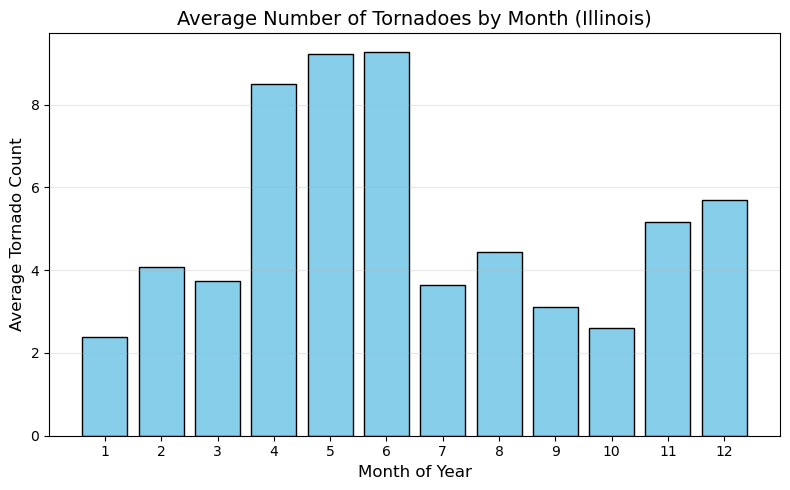

In [4]:
# Wanted to plot the average number of tornadoes by month of the year for
# Illinois as a sanity check.

# Plot the average number of tornadoes by month of the year (Illinois)

# Ensure tornado_df has 'date' column in datetime format
if not pd.api.types.is_datetime64_any_dtype(tornado_df['date']):
    tornado_df['date'] = pd.to_datetime(tornado_df['date'])

# Extract month from date
monthly_counts = tornado_df.copy()
monthly_counts['month'] = monthly_counts['date'].dt.month

# Calculate average tornadoes per month
avg_tornadoes_by_month = monthly_counts.groupby(
    'month')['tornado_count'].mean()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(
    avg_tornadoes_by_month.index,
    avg_tornadoes_by_month.values,
    color='skyblue',
    edgecolor='k')
plt.xlabel('Month of Year', fontsize=12)
plt.ylabel('Average Tornado Count', fontsize=12)
plt.title('Average Number of Tornadoes by Month (Illinois)', fontsize=14)
plt.xticks(range(1, 13))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

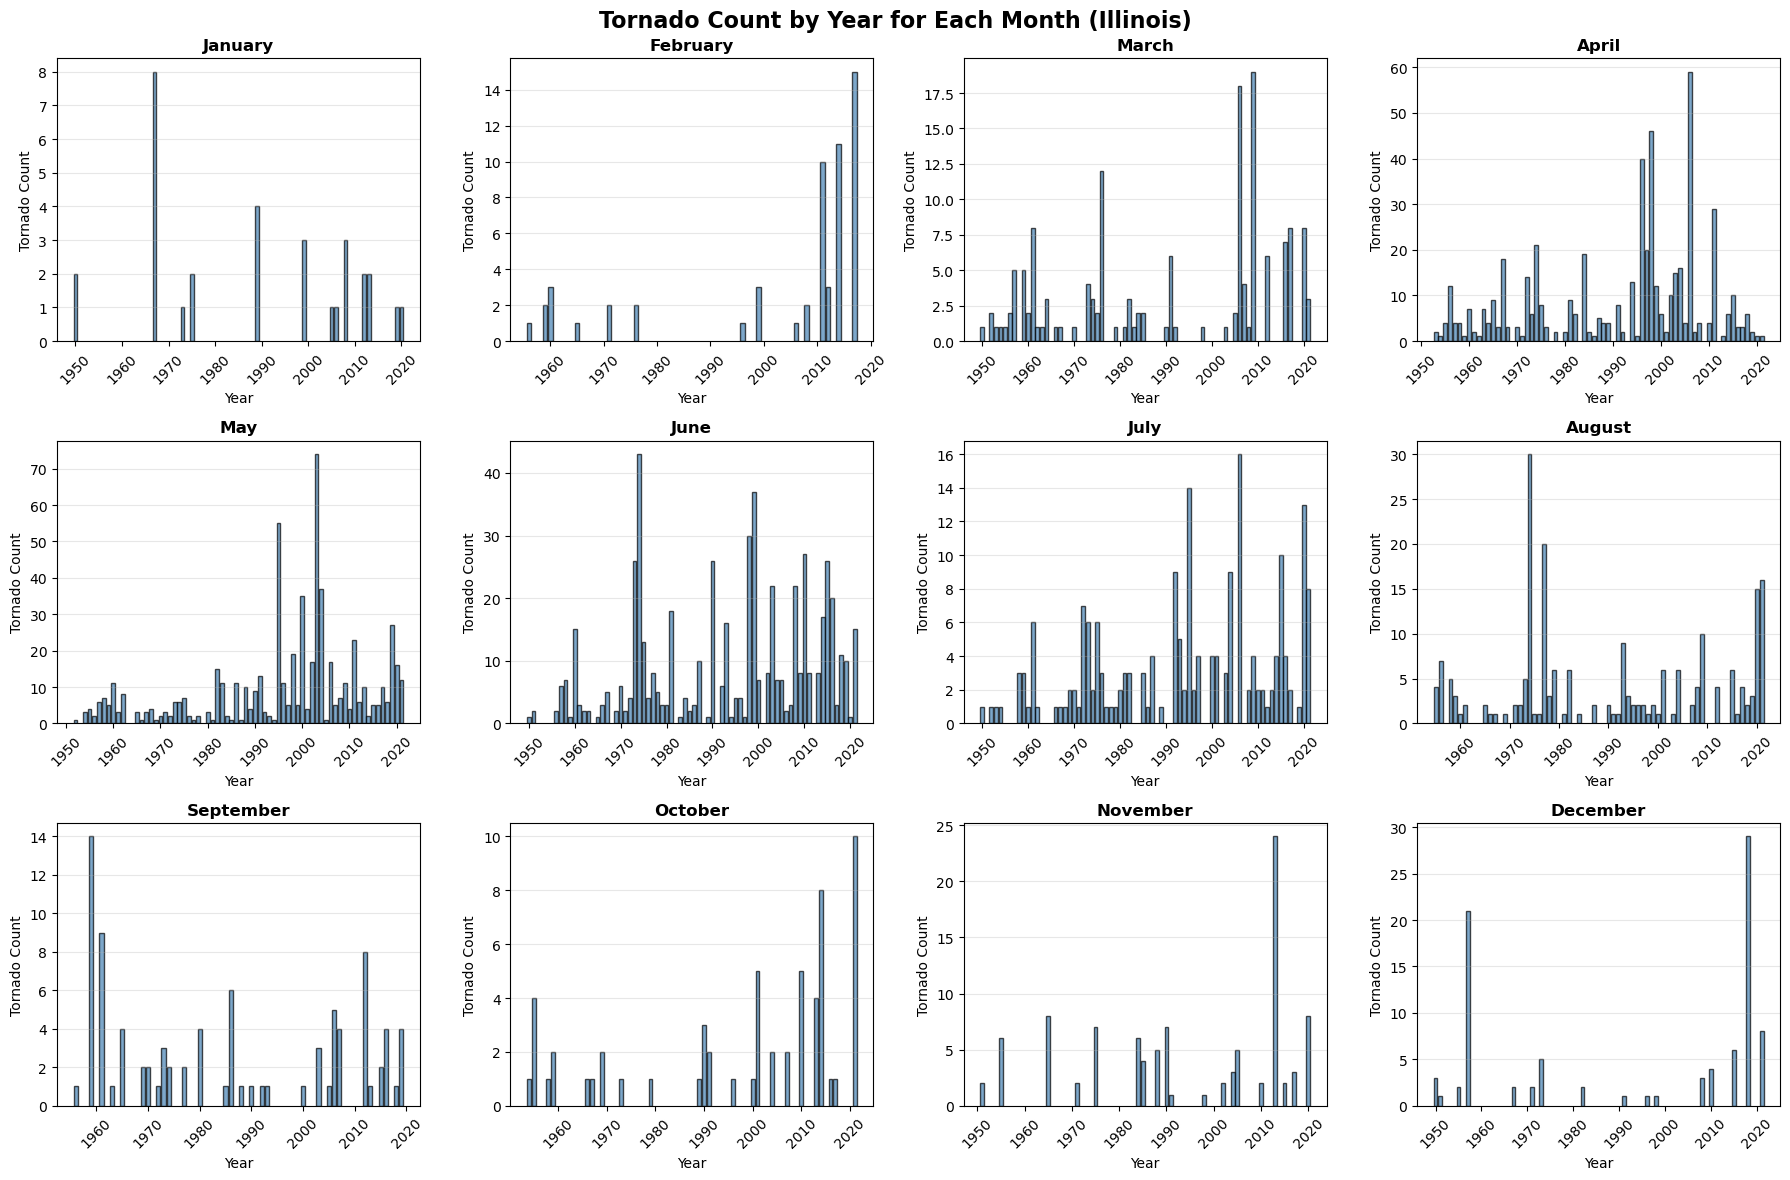

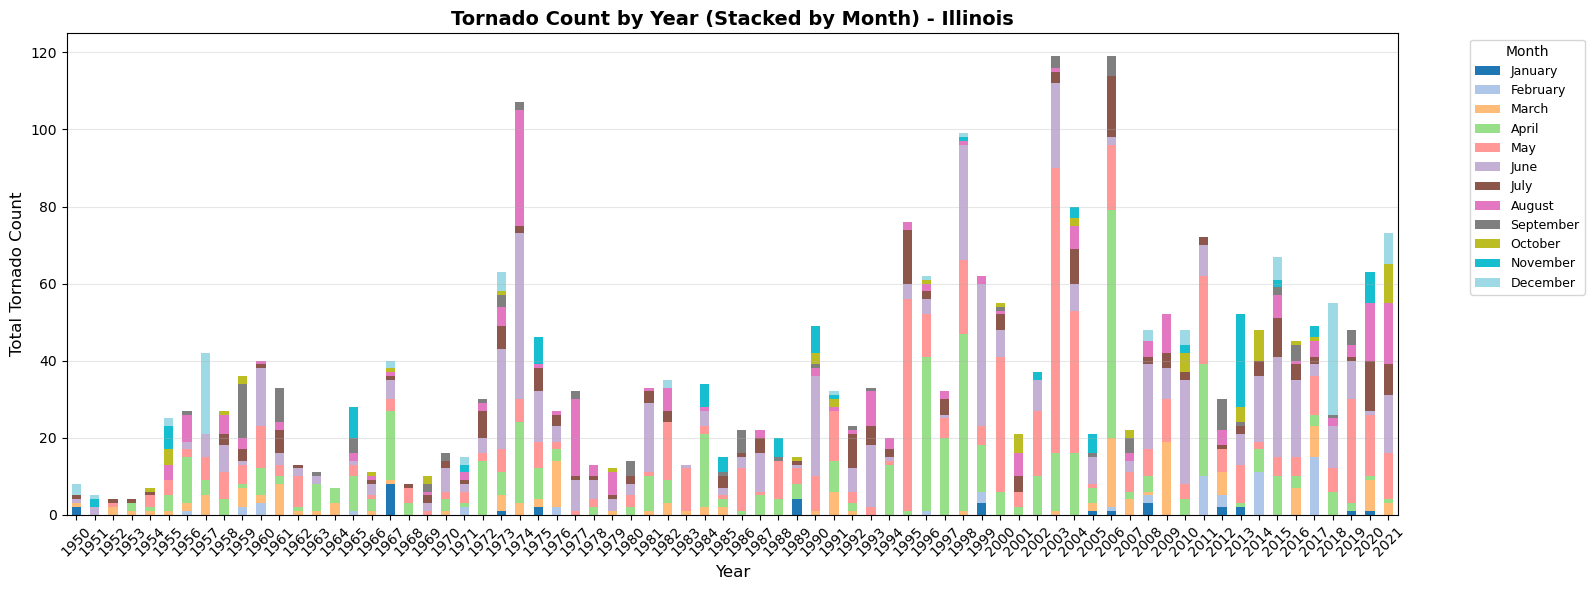

In [5]:
# Next, I wanted to see the results for each month of the year over all time to get a sense of the variability by year.
# Plot tornadoes in each month of each year as a bar chart over time

# Extract year and month from the date column
tornado_df['year'] = tornado_df['date'].dt.year
tornado_df['month'] = tornado_df['date'].dt.month

# Create a figure with subplots for each month
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
fig.suptitle(
    'Tornado Count by Year for Each Month (Illinois)',
    fontsize=16,
    fontweight='bold')

month_names = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'September',
    'October',
    'November',
    'December']

for month_idx in range(1, 13):
    # Determine subplot position
    row = (month_idx - 1) // 4
    col = (month_idx - 1) % 4
    ax = axes[row, col]

    # Filter data for this month
    month_data = tornado_df[tornado_df['month'] == month_idx].copy()
    month_data = month_data.sort_values('year')

    # Create bar chart
    ax.bar(
        month_data['year'],
        month_data['tornado_count'],
        color='steelblue',
        edgecolor='k',
        alpha=0.7)
    ax.set_title(month_names[month_idx - 1], fontsize=12, fontweight='bold')
    ax.set_xlabel('Year', fontsize=10)
    ax.set_ylabel('Tornado Count', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Alternative: Create a single stacked bar chart showing all months by year
fig, ax = plt.subplots(figsize=(16, 6))

# Create pivot table with years as index and months as columns
tornado_pivot = tornado_df.pivot_table(
    values='tornado_count',
    index='year',
    columns='month',
    aggfunc='sum',
    fill_value=0)

# Create stacked bar chart
tornado_pivot.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Total Tornado Count', fontsize=12)
ax.set_title(
    'Tornado Count by Year (Stacked by Month) - Illinois',
    fontsize=14,
    fontweight='bold')
ax.legend(
    title='Month',
    labels=month_names,
    bbox_to_anchor=(
        1.05,
        1),
    loc='upper left',
    fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2. Merge this monthly tornado dataset with the ENSO, PDO, NAO, and AO dataframe created in Module 4 Notebook 1.

In [6]:
# Open the climate indices dataset using Pandas
climate_df = pd.read_csv('climate_indices.csv')
print(climate_df.head())

         Date  ENSO   PDO   NAO     AO
0  1951-01-01   1.5 -1.19  0.08 -0.085
1  1951-02-01   0.9 -1.52  0.70 -0.400
2  1951-03-01  -0.1 -1.72 -1.02 -1.934
3  1951-04-01  -0.3 -1.35 -0.22 -0.776
4  1951-05-01  -0.7 -1.29 -0.59 -0.863


In [7]:
# Merge tornado data with climate indices on date
# First, ensure both date columns are in the same format
climate_df['Date'] = pd.to_datetime(climate_df['Date'])
tornado_df['date'] = pd.to_datetime(tornado_df['date'])

# Merge on date
merged_df = pd.merge(
    tornado_df,
    climate_df,
    left_on='date',
    right_on='Date',
    how='inner')

# Drop the duplicate 'Date' column and keep only 'date'
merged_df = merged_df.drop(columns=['Date'])

# Display the first rows and info about the merged dataframe
print("Merged dataframe shape:", merged_df.shape)
print("\nFirst few rows:")
print(merged_df.head())
print("\nDataframe info:")
print(merged_df.info())

Merged dataframe shape: (440, 8)

First few rows:
        date  tornado_count  year  month  ENSO   PDO   NAO     AO
0 1951-06-01              2  1951      6   0.2 -1.77 -1.64 -0.918
1 1951-11-01              2  1951     11  -0.8 -0.31 -0.39 -0.069
2 1951-12-01              1  1951     12  -0.7 -1.45  1.32  1.987
3 1952-03-01              2  1952      3   0.5 -1.67 -1.49 -1.859
4 1952-05-01              1  1952      5   0.8 -2.07 -1.12 -0.774

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           440 non-null    datetime64[ns]
 1   tornado_count  440 non-null    int64         
 2   year           440 non-null    int32         
 3   month          440 non-null    int32         
 4   ENSO           440 non-null    float64       
 5   PDO            440 non-null    float64       
 6   NAO            440 n

3. Create a random forest regression model and use features that include the 4 climate indices to predict the monthly number of tornadoes.  Create a scatter plot of the predicted and observed number of tornadoes over these states.  Report the correlation coefficient and RMSE of your model.

Random Forest Model Performance:
RMSE: 11.5790
R² Score: -0.0501
Correlation Coefficient: 0.0465


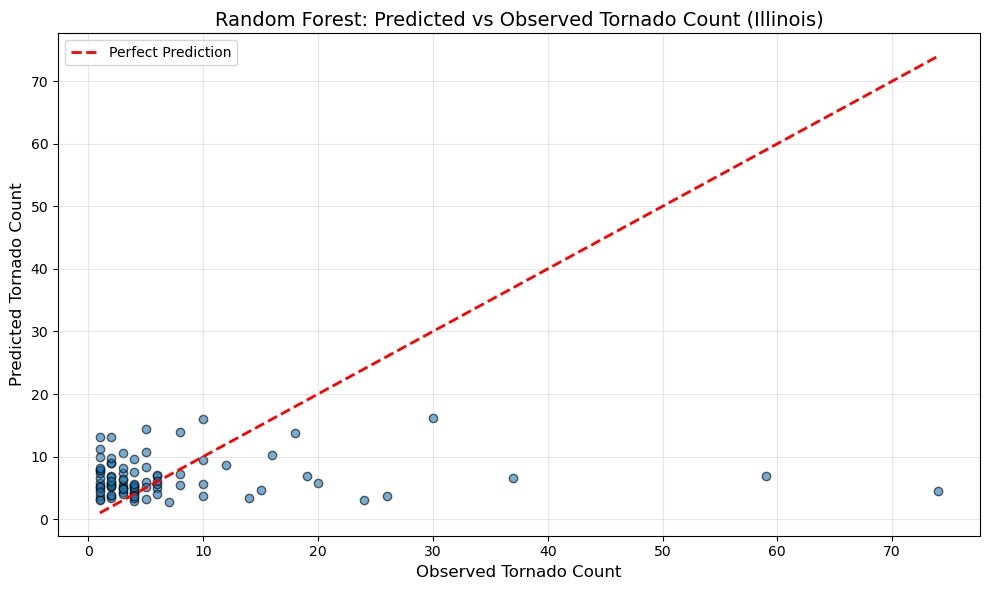


Test set size: 88 months
Mean observed tornado count: 7.18
Mean predicted tornado count: 6.60


In [8]:
# Prepare features and target
features = ['ENSO', 'PDO', 'NAO', 'AO']
X = merged_df[features]
y = merged_df['tornado_count']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
correlation = np.corrcoef(y_test, y_pred)[0, 1]

print(f"Random Forest Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Correlation Coefficient: {correlation:.4f}")

# Create scatter plot of predicted vs observed tornadoes
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Observed Tornado Count', fontsize=12)
plt.ylabel('Predicted Tornado Count', fontsize=12)
plt.title(
    'Random Forest: Predicted vs Observed Tornado Count (Illinois)',
    fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTest set size: {len(y_test)} months")
print(f"Mean observed tornado count: {y_test.mean():.2f}")
print(f"Mean predicted tornado count: {y_pred.mean():.2f}")

4. Create a one-hot encoding for the month of the year.  Repeat the scatterplot and compare the RMSE and correlation coefficient values.

Month one-hot encoding created.
Shape of merged dataframe with month encoding: (440, 19)
Month columns: ['month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']

Random Forest Model with Month One-Hot Encoding:
RMSE: 10.9169
R² Score: 0.0665
Correlation Coefficient: 0.2611

Model Comparison:
Metric                    Without Month        With Month          
-----------------------------------------------------------------
RMSE                      11.5790              10.9169             
R² Score                  -0.0501              0.0665              
Correlation               0.0465               0.2611              

Improvements with Month Encoding:
RMSE Improvement: 5.72%
R² Improvement: 232.68%
Correlation Improvement: 461.29%

Random Forest Model with Month One-Hot Encoding:
RMSE: 10.9169
R² Score: 0.0665
Correlation Coefficient: 0.2611

Model Comparison:
Metric                    Without Month        With M

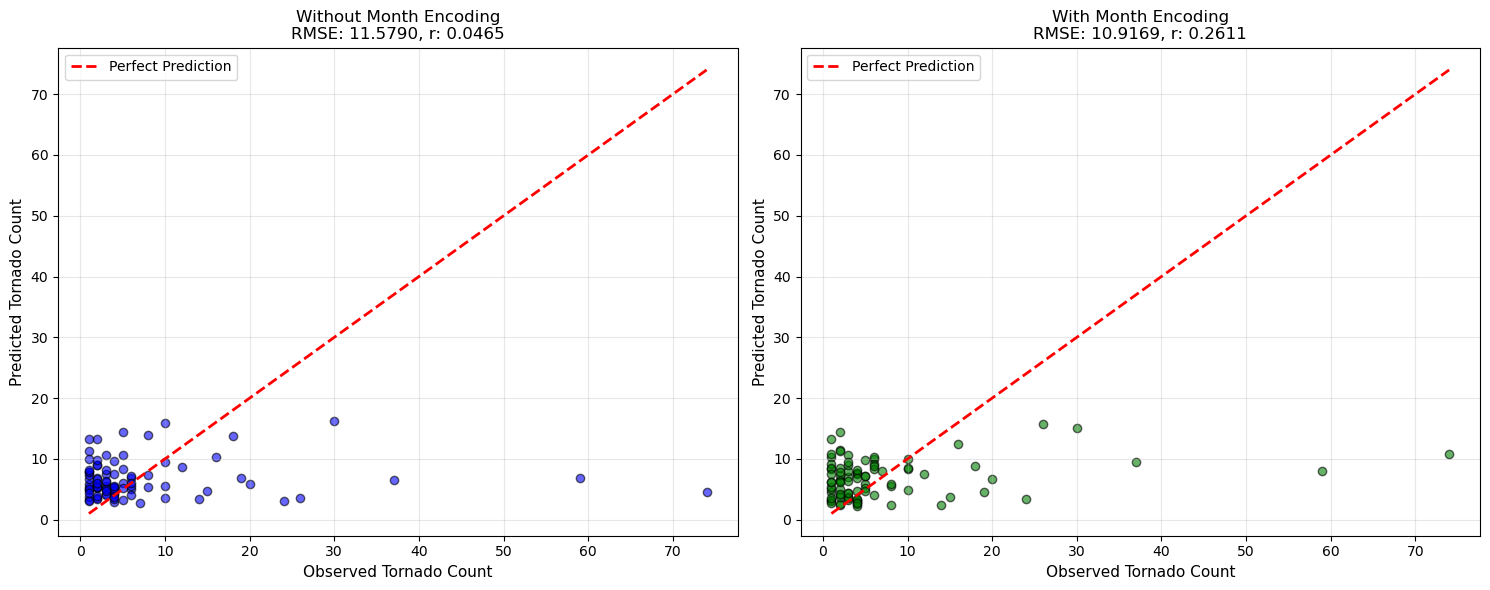

In [9]:
# Create a copy of merged_df to add month features
merged_df_with_month = merged_df.copy()

# Extract month from the date column
merged_df_with_month['month'] = merged_df_with_month['date'].dt.month

# Create one-hot encoding for months (drop first to avoid multicollinearity)
month_dummies = pd.get_dummies(
    merged_df_with_month['month'],
    prefix='month',
    drop_first=True)

# Add the month dummy variables to the dataframe
merged_df_with_month = pd.concat([merged_df_with_month, month_dummies], axis=1)

print("Month one-hot encoding created.")
print(
    f"Shape of merged dataframe with month encoding: {
        merged_df_with_month.shape}")
print(
    f"Month columns: {[col for col in merged_df_with_month.columns if col.startswith('month_')]}")

# Prepare features including climate indices and month dummies
climate_features = ['ENSO', 'PDO', 'NAO', 'AO']
month_features = [
    col for col in merged_df_with_month.columns if col.startswith('month_')]
all_features = climate_features + month_features

X_with_month = merged_df_with_month[all_features]
y_with_month = merged_df_with_month['tornado_count']

# Split data into training and testing sets
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_with_month, y_with_month, test_size=0.2, random_state=42)

# Create and train the Random Forest Regressor with month features
rf_model_month = RandomForestRegressor(
    n_estimators=100, random_state=42, n_jobs=-1)
rf_model_month.fit(X_train_m, y_train_m)

# Make predictions
y_pred_month = rf_model_month.predict(X_test_m)

# Calculate performance metrics
rmse_month = np.sqrt(mean_squared_error(y_test_m, y_pred_month))
r2_month = r2_score(y_test_m, y_pred_month)
correlation_month = np.corrcoef(y_test_m, y_pred_month)[0, 1]

print(f"\n{'=' * 60}")
print(f"Random Forest Model with Month One-Hot Encoding:")
print(f"{'=' * 60}")
print(f"RMSE: {rmse_month:.4f}")
print(f"R² Score: {r2_month:.4f}")
print(f"Correlation Coefficient: {correlation_month:.4f}")

# Compare with the original model
print(f"\n{'=' * 60}")
print(f"Model Comparison:")
print(f"{'=' * 60}")
print(f"{'Metric':<25} {'Without Month':<20} {'With Month':<20}")
print(f"{'-' * 65}")
print(f"{'RMSE':<25} {rmse:<20.4f} {rmse_month:<20.4f}")
print(f"{'R² Score':<25} {r2:<20.4f} {r2_month:<20.4f}")
print(f"{'Correlation':<25} {correlation:<20.4f} {correlation_month:<20.4f}")

# Calculate improvements
rmse_improvement = ((rmse - rmse_month) / rmse) * 100
r2_improvement = ((r2_month - r2) / abs(r2)) * 100
correlation_improvement = (
    (correlation_month - correlation) / abs(correlation)) * 100

print(f"\n{'Improvements with Month Encoding:':<25}")
print(f"{'RMSE Improvement: {:.2f}%'.format(rmse_improvement)}")
print(f"{'R² Improvement: {:.2f}%'.format(r2_improvement)}")
print(f"{'Correlation Improvement: {:.2f}%'.format(correlation_improvement)}")

# Create side-by-side scatter plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Without month encoding
axes[0].scatter(y_test, y_pred, alpha=0.6, edgecolors='k', color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(),
             y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Observed Tornado Count', fontsize=11)
axes[0].set_ylabel('Predicted Tornado Count', fontsize=11)
axes[0].set_title(
    f'Without Month Encoding\nRMSE: {
        rmse:.4f}, r: {
            correlation:.4f}',
    fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: With month encoding
axes[1].scatter(
    y_test_m,
    y_pred_month,
    alpha=0.6,
    edgecolors='k',
    color='green')
axes[1].plot([y_test_m.min(), y_test_m.max()], [y_test_m.min(),
             y_test_m.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Observed Tornado Count', fontsize=11)
axes[1].set_ylabel('Predicted Tornado Count', fontsize=11)
axes[1].set_title(
    f'With Month Encoding\nRMSE: {
        rmse_month:.4f}, r: {
            correlation_month:.4f}',
    fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

5. Perform a feature importance and multipass permutation analysis of your features.

CLIMATE INDICES ONLY - Excluding Month Features from Analysis

Feature Importance - Climate Indices Only
(Excludes all month features)
feature  importance
    PDO    0.237371
    NAO    0.236546
     AO    0.194997
   ENSO    0.177759

Permutation Importance (Single Pass - 10 repeats)
Climate Indices Only (Excludes all month features)
feature  importance_mean  importance_std
    NAO         0.040381        0.018421
    PDO         0.009445        0.012482
   ENSO         0.006978        0.075940
     AO         0.005323        0.038159

Permutation Importance (Single Pass - 10 repeats)
Climate Indices Only (Excludes all month features)
feature  importance_mean  importance_std
    NAO         0.040381        0.018421
    PDO         0.009445        0.012482
   ENSO         0.006978        0.075940
     AO         0.005323        0.038159

Permutation Importance (Multipass - 30 repeats)
Climate Indices Only (Excludes all month features)
feature  importance_mean  importance_std
    NAO   

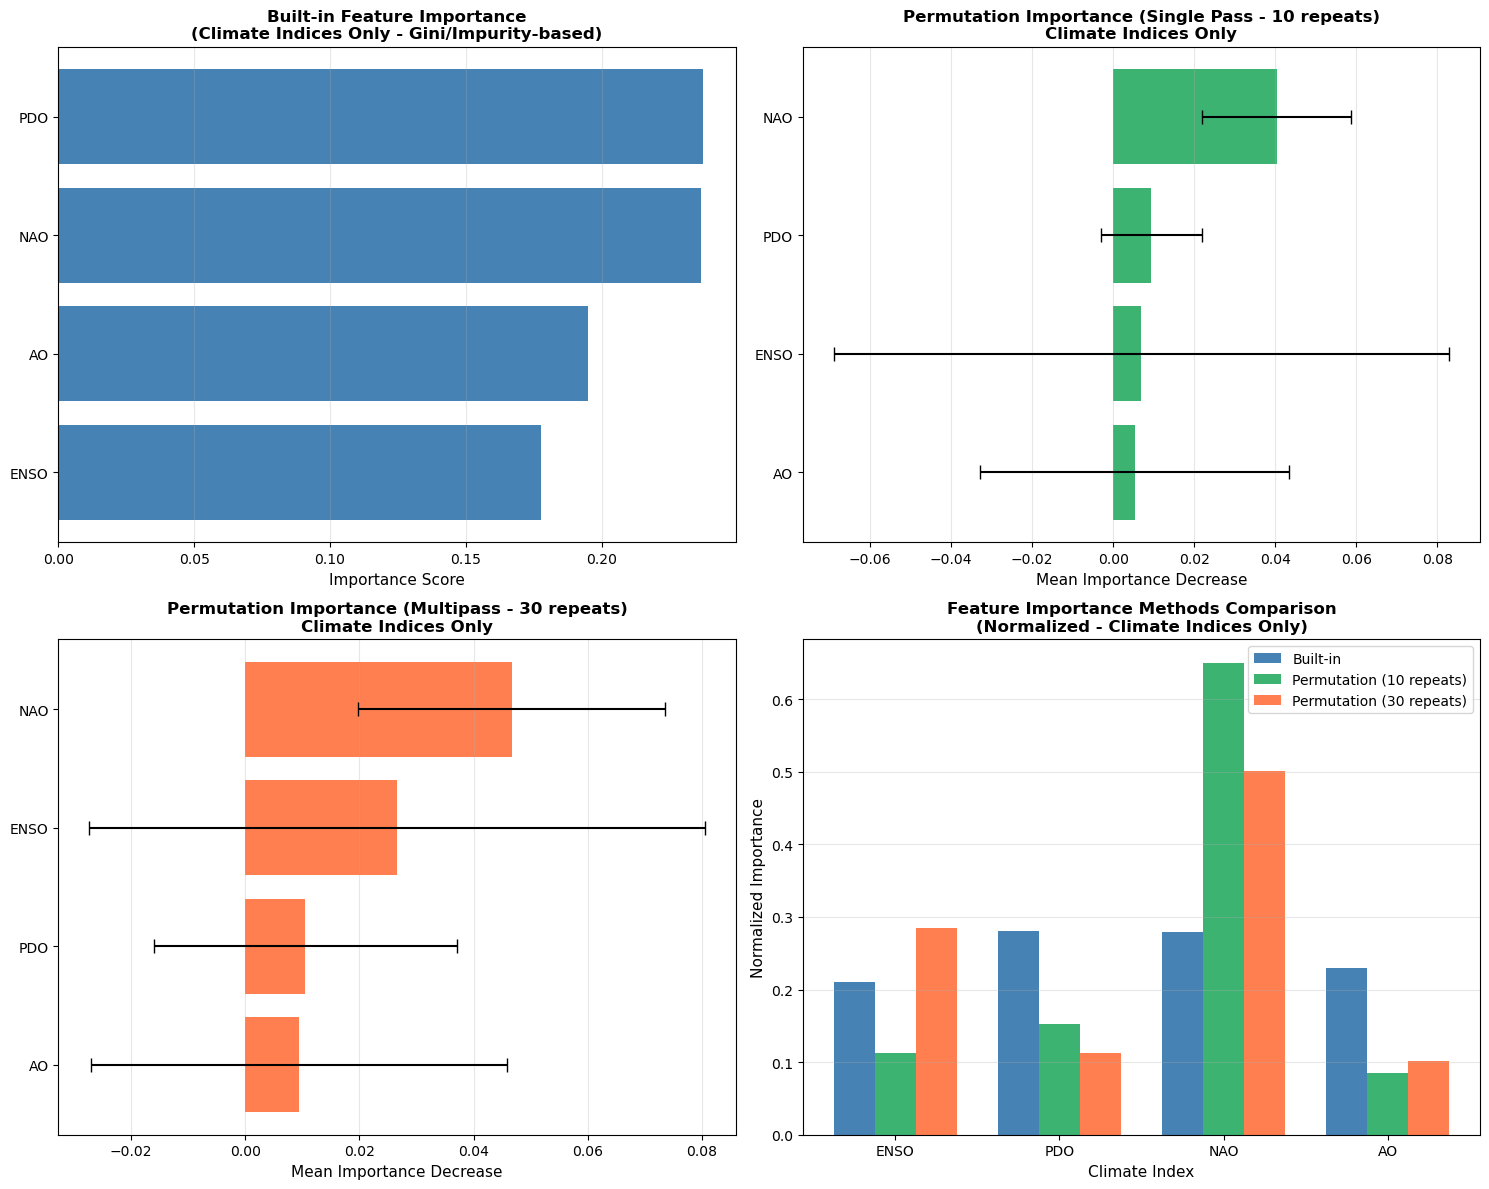

Summary: Feature Importance Statistics (Climate Indices Only)

Multipass Permutation Importance Ranking (Climate Indices Only):
Rank     Feature    Mean Importance      Std Dev        
-------------------------------------------------------
1        NAO        0.046633             0.026926       
2        ENSO       0.026586             0.053877       
3        PDO        0.010521             0.026561       
4        AO         0.009430             0.036455       

Relative Importance (% of total climate index contribution):
Feature         Percentage     
------------------------------
NAO              50.05%
ENSO             28.53%
PDO              11.29%
AO               10.12%

Most Important Climate Index:  NAO
Least Important Climate Index: AO



In [10]:
# ============================================================================
# Feature Importance Analysis (Climate Indices Only - NO MONTHS)
# ============================================================================

# Focus ONLY on climate indices (excluding all month features)
climate_indices_only = ['ENSO', 'PDO', 'NAO', 'AO']

print("=" * 70)
print("CLIMATE INDICES ONLY - Excluding Month Features from Analysis")
print("=" * 70)

# Get feature importances from the model with month encoding
feature_importance = rf_model_month.feature_importances_
feature_names = all_features

# Create a dataframe for better visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Filter to climate indices only (EXCLUDE months)
importance_df_climate = importance_df[importance_df['feature'].isin(
    climate_indices_only)].sort_values('importance', ascending=False)

print("\n" + "=" * 60)
print("Feature Importance - Climate Indices Only")
print("(Excludes all month features)")
print("=" * 60)
print(importance_df_climate.to_string(index=False))
print()

# ============================================================================
# Permutation Importance Analysis (Single Pass) - Climate Indices Only
# ============================================================================

# Calculate permutation importance on full model
perm_importance = permutation_importance(
    rf_model_month, X_test_m, y_test_m,
    n_repeats=10, random_state=42, n_jobs=-1
)

perm_importance_df_full = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
})

# Filter to climate indices only (EXCLUDE months)
perm_importance_df = perm_importance_df_full[perm_importance_df_full['feature'].isin(
    climate_indices_only)].sort_values('importance_mean', ascending=False)

print("=" * 60)
print("Permutation Importance (Single Pass - 10 repeats)")
print("Climate Indices Only (Excludes all month features)")
print("=" * 60)
print(perm_importance_df.to_string(index=False))
print()

# ============================================================================
# Multipass Permutation Importance Analysis - Climate Indices Only
# ============================================================================

# Perform permutation importance with multiple repeats (multipass)
multipass_repeats = 30
perm_importance_multipass = permutation_importance(
    rf_model_month, X_test_m, y_test_m,
    n_repeats=multipass_repeats, random_state=42, n_jobs=-1
)

perm_importance_multipass_df_full = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance_multipass.importances_mean,
    'importance_std': perm_importance_multipass.importances_std
})

# Filter to climate indices only (EXCLUDE months)
perm_importance_multipass_df = perm_importance_multipass_df_full[perm_importance_multipass_df_full['feature'].isin(
    climate_indices_only)].sort_values('importance_mean', ascending=False)

print("=" * 60)
print(f"Permutation Importance (Multipass - {multipass_repeats} repeats)")
print("Climate Indices Only (Excludes all month features)")
print("=" * 60)
print(perm_importance_multipass_df.to_string(index=False))
print()

# ============================================================================
# Visualization of Feature Importance - Climate Indices Only
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Built-in Feature Importance (Climate Indices)
ax1 = axes[0, 0]
importance_df_climate_sorted = importance_df_climate.sort_values(
    'importance', ascending=True)
ax1.barh(
    importance_df_climate_sorted['feature'],
    importance_df_climate_sorted['importance'],
    color='steelblue')
ax1.set_xlabel('Importance Score', fontsize=11)
ax1.set_title(
    'Built-in Feature Importance\n(Climate Indices Only - Gini/Impurity-based)',
    fontsize=12,
    fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Permutation Importance (Single Pass) - Climate Indices
ax2 = axes[0, 1]
perm_df_sorted = perm_importance_df.sort_values(
    'importance_mean', ascending=True)
ax2.barh(
    perm_df_sorted['feature'],
    perm_df_sorted['importance_mean'],
    xerr=perm_df_sorted['importance_std'],
    color='mediumseagreen',
    capsize=5)
ax2.set_xlabel('Mean Importance Decrease', fontsize=11)
ax2.set_title(
    f'Permutation Importance (Single Pass - 10 repeats)\nClimate Indices Only',
    fontsize=12,
    fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: Multipass Permutation Importance - Climate Indices
ax3 = axes[1, 0]
multipass_df_sorted = perm_importance_multipass_df.sort_values(
    'importance_mean', ascending=True)
ax3.barh(
    multipass_df_sorted['feature'],
    multipass_df_sorted['importance_mean'],
    xerr=multipass_df_sorted['importance_std'],
    color='coral',
    capsize=5)
ax3.set_xlabel('Mean Importance Decrease', fontsize=11)
ax3.set_title(
    f'Permutation Importance (Multipass - {multipass_repeats} repeats)\nClimate Indices Only',
    fontsize=12,
    fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Plot 4: Comparison of all three methods - Climate Indices
ax4 = axes[1, 1]

# Normalize scores for comparison
built_in_norm = importance_df_climate.set_index(
    'feature')['importance'].reindex(climate_indices_only)
perm_single_norm = perm_importance_df.set_index(
    'feature')['importance_mean'].reindex(climate_indices_only)
perm_multi_norm = perm_importance_multipass_df.set_index(
    'feature')['importance_mean'].reindex(climate_indices_only)

# Normalize each method to sum to 1 for fair comparison
built_in_norm = built_in_norm / built_in_norm.sum()
perm_single_norm = perm_single_norm / perm_single_norm.sum()
perm_multi_norm = perm_multi_norm / perm_multi_norm.sum()

x = np.arange(len(climate_indices_only))
width = 0.25

ax4.bar(
    x - width,
    built_in_norm.values,
    width,
    label='Built-in',
    color='steelblue')
ax4.bar(
    x,
    perm_single_norm.values,
    width,
    label='Permutation (10 repeats)',
    color='mediumseagreen')
ax4.bar(
    x + width,
    perm_multi_norm.values,
    width,
    label=f'Permutation ({multipass_repeats} repeats)',
    color='coral')

ax4.set_xlabel('Climate Index', fontsize=11)
ax4.set_ylabel('Normalized Importance', fontsize=11)
ax4.set_title(
    'Feature Importance Methods Comparison\n(Normalized - Climate Indices Only)',
    fontsize=12,
    fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(climate_indices_only)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================================
# Summary Statistics - Climate Indices Only
# ============================================================================

print("=" * 70)
print("Summary: Feature Importance Statistics (Climate Indices Only)")
print("=" * 70)

print(f"\nMultipass Permutation Importance Ranking (Climate Indices Only):")
print(f"{'Rank':<8} {'Feature':<10} {'Mean Importance':<20} {'Std Dev':<15}")
print(f"{'-' * 55}")
for idx, (_, row) in enumerate(perm_importance_multipass_df.iterrows(), 1):
    print(
        f"{
            idx:<8} {
            row['feature']:<10} {
                row['importance_mean']:<20.6f} {
                    row['importance_std']:<15.6f}")

# Calculate percentages
total_importance = perm_importance_multipass_df['importance_mean'].sum()
print(f"\nRelative Importance (% of total climate index contribution):")
print(f"{'Feature':<15} {'Percentage':<15}")
print(f"{'-' * 30}")
for _, row in perm_importance_multipass_df.iterrows():
    pct = (row['importance_mean'] / total_importance) * 100
    print(f"{row['feature']:<15} {pct:>6.2f}%")

print(f"\n{'=' * 70}")
print(
    f"Most Important Climate Index:  {
        perm_importance_multipass_df.iloc[0]['feature']}")
print(
    f"Least Important Climate Index: {perm_importance_multipass_df.iloc[-1]['feature']}")
print(f"{'=' * 70}\n")

6. Create a SHAP Summary Plot showing feature importance and feature effects.

Generating SHAP Beeswarm plot for all features...
Error with beeswarm plot: 'Axes' object has no attribute 'update_layout'
Error with beeswarm plot: 'Axes' object has no attribute 'update_layout'


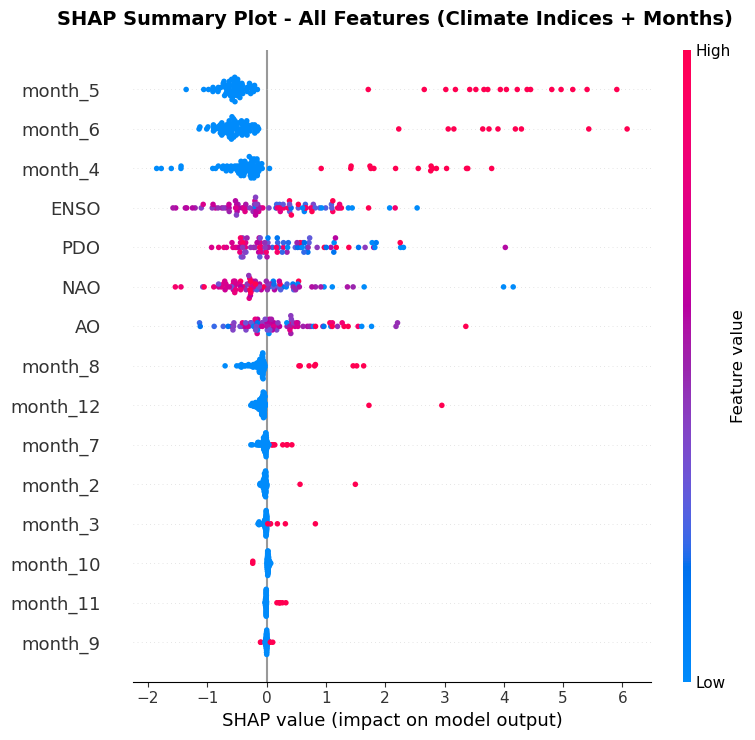

In [11]:
print("Generating SHAP Beeswarm plot for all features...")

# Create SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(rf_model_month)
shap_values = explainer.shap_values(X_test_m)

# Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test_m.values,
    feature_names=list(X_test_m.columns)
)

# Plot SHAP beeswarm - handle both Matplotlib and Plotly backends
try:
    fig = shap.plots.beeswarm(explanation, show=False)
    if fig is not None:
        # Plotly backend - update layout
        fig.update_layout(
            title_text="SHAP Beeswarm Plot - All Features (Climate Indices + Months)",
            title_font=dict(
                size=14,
                family="Arial",
                color="black"))
        fig.show()
    else:
        # Matplotlib backend - just show the plot
        plt.suptitle(
            "SHAP Beeswarm Plot - All Features (Climate Indices + Months)",
            fontsize=14,
            fontweight='bold')
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"Error with beeswarm plot: {e}")
    # Fallback to summary plot with dot style
    shap.summary_plot(
        shap_values,
        X_test_m,
        feature_names=list(
            X_test_m.columns),
        plot_type="dot",
        show=False)
    plt.suptitle(
        "SHAP Summary Plot - All Features (Climate Indices + Months)",
        fontsize=14,
        fontweight='bold')
    plt.tight_layout()
    plt.show()

7. Create a SHAP Feature Dependence for the ENSO index.

SHAP Feature Dependence Analysis - ENSO Index
Climate Indices Only (Excluding Month Features)


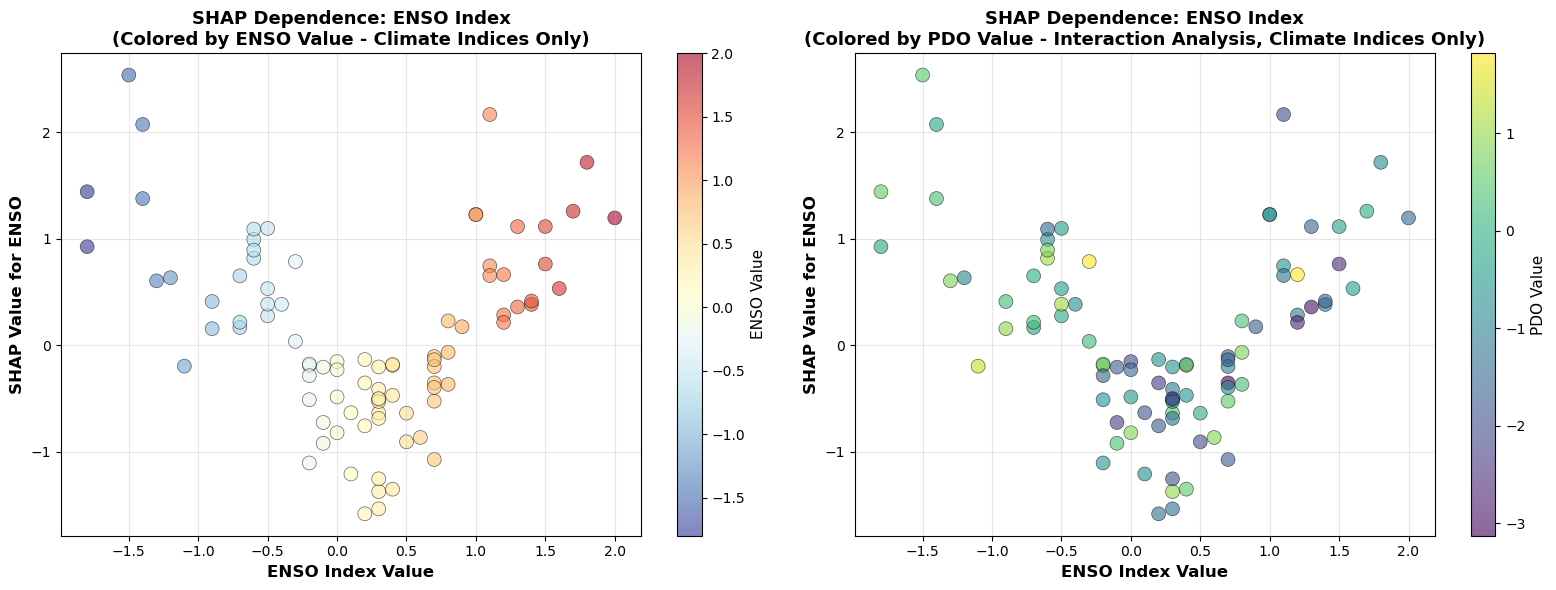


ENSO SHAP Value Statistics (Climate Indices Only)
Mean SHAP value for ENSO:        0.101575
Std Dev SHAP value for ENSO:     0.854122
Max SHAP value for ENSO:         2.537950
Min SHAP value for ENSO:         -1.580260
Mean |SHAP| for ENSO:            0.693697

Correlation (ENSO value vs SHAP): -0.086444

Examples of ENSO Impact on Tornado Predictions

Strongest Positive ENSO Impact (increases tornado count prediction):
  ENSO Value:  -1.5000
  SHAP Value: 2.537950
  Observed Tornado Count:      8

Strongest Negative ENSO Impact (decreases tornado count prediction):
  ENSO Value:   0.2000
  SHAP Value: -1.580260
  Observed Tornado Count:      1

Climate Indices Ranking by Mean |SHAP| Value (Climate Indices Only)
feature  mean_abs_shap
   ENSO       0.693697
    PDO       0.633731
    NAO       0.556934
     AO       0.550638

Relative Importance (% of Climate Indices)
ENSO             28.49%
PDO              26.03%
NAO              22.87%
AO               22.61%

ENSO Rank Among Clima

In [12]:
print("=" * 70)
print("SHAP Feature Dependence Analysis - ENSO Index")
print("Climate Indices Only (Excluding Month Features)")
print("=" * 70)

# Define climate indices only (NO MONTHS)
climate_indices_only = ['ENSO', 'PDO', 'NAO', 'AO']
climate_feature_indices = [all_features.index(
    feat) for feat in climate_indices_only]

# Filter SHAP values to climate indices only
shap_values_climate = shap_values[:, climate_feature_indices]
X_test_m_climate = X_test_m[climate_indices_only]

# Get the index of ENSO in the climate indices
enso_idx = climate_indices_only.index('ENSO')
pdo_idx = climate_indices_only.index('PDO')

# Extract SHAP values for ENSO
enso_shap = shap_values_climate[:, enso_idx]
enso_values = X_test_m_climate['ENSO'].values
pdo_values = X_test_m_climate['PDO'].values

# ============================================================================
# SHAP Feature Dependence Plot for ENSO - Climate Indices Only
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: ENSO SHAP dependence colored by ENSO value
scatter1 = axes[0].scatter(
    enso_values,
    enso_shap,
    c=enso_values,
    cmap='RdYlBu_r',
    s=100,
    alpha=0.6,
    edgecolors='k',
    linewidth=0.5)
axes[0].set_xlabel('ENSO Index Value', fontsize=12, fontweight='bold')
axes[0].set_ylabel('SHAP Value for ENSO', fontsize=12, fontweight='bold')
axes[0].set_title(
    'SHAP Dependence: ENSO Index\n(Colored by ENSO Value - Climate Indices Only)',
    fontsize=13,
    fontweight='bold')
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('ENSO Value', fontsize=11)

# Plot 2: ENSO SHAP dependence colored by PDO value (interaction analysis)
scatter2 = axes[1].scatter(
    enso_values,
    enso_shap,
    c=pdo_values,
    cmap='viridis',
    s=100,
    alpha=0.6,
    edgecolors='k',
    linewidth=0.5)
axes[1].set_xlabel('ENSO Index Value', fontsize=12, fontweight='bold')
axes[1].set_ylabel('SHAP Value for ENSO', fontsize=12, fontweight='bold')
axes[1].set_title(
    'SHAP Dependence: ENSO Index\n(Colored by PDO Value - Interaction Analysis, Climate Indices Only)',
    fontsize=13,
    fontweight='bold')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('PDO Value', fontsize=11)

plt.tight_layout()
plt.show()

# ============================================================================
# ENSO SHAP Statistics - Climate Indices Only
# ============================================================================

print("\n" + "=" * 70)
print("ENSO SHAP Value Statistics (Climate Indices Only)")
print("=" * 70)
print(f"Mean SHAP value for ENSO:        {enso_shap.mean():.6f}")
print(f"Std Dev SHAP value for ENSO:     {enso_shap.std():.6f}")
print(f"Max SHAP value for ENSO:         {enso_shap.max():.6f}")
print(f"Min SHAP value for ENSO:         {enso_shap.min():.6f}")
print(f"Mean |SHAP| for ENSO:            {np.abs(enso_shap).mean():.6f}")

# Correlation between ENSO value and SHAP value
enso_corr = np.corrcoef(enso_values, enso_shap)[0, 1]
print(f"\nCorrelation (ENSO value vs SHAP): {enso_corr:.6f}")

# Find examples of max positive and negative ENSO impact
max_positive_idx = np.argmax(enso_shap)
max_negative_idx = np.argmin(enso_shap)

print(f"\n" + "=" * 70)
print("Examples of ENSO Impact on Tornado Predictions")
print("=" * 70)
print(f"\nStrongest Positive ENSO Impact (increases tornado count prediction):")
print(f"  ENSO Value: {enso_values[max_positive_idx]:>8.4f}")
print(f"  SHAP Value: {enso_shap[max_positive_idx]:>8.6f}")
print(f"  Observed Tornado Count: {y_test_m.iloc[max_positive_idx]:>6.0f}")

print(f"\nStrongest Negative ENSO Impact (decreases tornado count prediction):")
print(f"  ENSO Value: {enso_values[max_negative_idx]:>8.4f}")
print(f"  SHAP Value: {enso_shap[max_negative_idx]:>8.6f}")
print(f"  Observed Tornado Count: {y_test_m.iloc[max_negative_idx]:>6.0f}")

# ============================================================================
# Climate Indices Comparison - SHAP Importance - Climate Indices Only
# ============================================================================

print(f"\n" + "=" * 70)
print("Climate Indices Ranking by Mean |SHAP| Value (Climate Indices Only)")
print("=" * 70)

# Calculate mean absolute SHAP for each climate index
climate_shap_analysis = pd.DataFrame({
    'feature': climate_indices_only,
    'mean_abs_shap': [np.abs(shap_values_climate[:, i]).mean() for i in range(len(climate_indices_only))]
}).sort_values('mean_abs_shap', ascending=False)

print(climate_shap_analysis.to_string(index=False))

# Calculate percentages
total_shap_climate = climate_shap_analysis['mean_abs_shap'].sum()
climate_shap_analysis['percentage'] = (
    climate_shap_analysis['mean_abs_shap'] /
    total_shap_climate *
    100)

print(f"\n" + "=" * 70)
print("Relative Importance (% of Climate Indices)")
print("=" * 70)
for _, row in climate_shap_analysis.iterrows():
    print(f"{row['feature']:<15} {row['percentage']:>6.2f}%")

print(f"\n{'=' * 70}")
print(
    f"ENSO Rank Among Climate Indices: {
        list(
            climate_shap_analysis['feature']).index('ENSO') +
        1} of {
        len(climate_indices_only)}")
print(f"{'=' * 70}\n")

8. Any observations on the importance of the various features in your model from the XAI techniques you tried?
1) None of these features seems highly predictive of tornado generation in any given month of the year.  The absolute results are:

Relative Importance (% of total climate index contribution):
    Feature                                         Percentage     
    ------------------------------
    North Atlantic Oscillation (NAO)                50.05%
    El Nino-Southern Oscillation (ENSO)             28.53%
    Pacific Decadal Oscillation (PDO)               11.29%
    Artic Oscillation (AO)                          10.12%

This compares to absolute results:
    Multipass Permutation Importance Ranking (Climate Indices Only):
    Rank     Feature    Mean Importance      Std Dev        
    -------------------------------------------------------
    1        NAO        0.046633             0.026926       
    2        ENSO       0.026586             0.053877       
    3        PDO        0.010521             0.026561       
    4        AO         0.009430             0.036455

My interpreation is that the NAO is the most important feature with a moderate standard deviation indicatating it is relatively stable in its impact.

The ENSO is second (behind by quite bit), but exibhits a lot more variability in the impact.

PDO is a fair amount behind ENSO, but exhibits less variability. AO is the least important in the model.

2) Without one-hot encoding the model is basically meaningless based on the following results: 
    RMSE: 11.5790
    R² Score: -0.0501
    Correlation Coefficient: 0.0465

One hot encoding to account for month of the year does improve the results by quite a bit. However, the scores are still not particularly high.
    RMSE: 10.9169
    R² Score: 0.0665
    Correlation Coefficient: 0.2611

I don't find these model results particularly surprising since tornadoes tend to occur in outbreaks. 

That is demonstrated visually (if not statistically) in the plot that I did showing tornado counts by month.  So a single day in a state could easily have more than the monthly average, while other peak months may have few or none in a specific year.

Also limiting the correlation is the fact that we are looking at one state.  So if we were to look at the entire United States, our sample would be bigger, with more data points to identify a correlation.